In [1]:
import pandas as pd
import numpy as np
import datetime

import sys
sys.path.append("scripts/")
sys.path.insert(1, '../../scripts/')
from s3_support import *

In [2]:
%matplotlib inline

# load data

In [3]:
START_DATE = '2024-01-01'

In [4]:
# form status; template 8 is new standard form
q = "select id, status, template from form"
all_forms = redshift_query_read(q, schema='production')
active_forms = all_forms[all_forms['status']==1]['id'].tolist()

In [5]:
print("{:,} forms".format(len(all_forms)))
print("{:,} forms with active status".format(len(active_forms)))

143,029 forms
59,481 forms with active status


### embeds

In [6]:
# embeds
q = "select widget as form from embed"
embeds = redshift_query_read(q, schema='production')

In [7]:
def is_embed(r):
    if r['form'] in embeds['form'].unique().tolist():
        return True
    return False

### form upgrades

In [8]:
# logged upgrades
q = "select * from syslog_logs where message like '%Qgiv Form Template Upgraded%'"
form_upgrades = redshift_query_read(q, schema="production")[['org', 'form', 'created']]
forms_upgrades_ids_logged = form_upgrades['form'].unique().tolist()

In [9]:
print("first form upgrade: {}".format(form_upgrades['created'].min()))
print("last form upgrade: {}".format(form_upgrades['created'].max()))

first form upgrade: 2020-12-09 15:30:17
last form upgrade: 2025-01-08 08:45:38


In [10]:
# created new template forms
new_forms_ids = all_forms[all_forms['template']==8]['id'].unique().tolist()

In [ ]:
print("{:,} forms upgraded (noted in logs)".format(len(forms_upgrades_ids_logged)))
print("{:,} forms with new template (production export)".format(len(new_forms_ids)))
print("{:,} forms with new template and active status (production export)".format(len(new_forms_ids)))
print()
print("{:,} new template forms & active".format(len([f for f in set(forms_upgrades_ids_logged + new_forms_ids) if f in active_forms])))
print("\n\nlog entries do not imply form status, so we may see an excess but status filters will be applied to remove non-active forms from the dataset")

29,781 forms upgraded (noted in logs)
88,492 forms with new template (production export)
88,492 forms with new template and active status (production export)

40,548 new template forms & active


log entries do not imply form status, so here we see an excess but status filters will be applied to remove non-active forms from the dataset


In [12]:
form_upgrades['month'] = form_upgrades['created'].dt.to_period('M')
form_upgrades['active'] = form_upgrades['form'].isin(active_forms)
monthly_upgrades = form_upgrades.groupby(['month', 'active'])['form'].nunique().reset_index()
monthly_upgrades = monthly_upgrades.pivot(index='month', columns='active', values='form').reset_index()
monthly_upgrades.columns = ['month', 'not active', 'active']

print("template conversions")
monthly_upgrades

template conversions


,month,not active,active
0,2020-12,88.0,125.0
1,2021-01,290.0,206.0
2,2021-02,218.0,210.0
3,2021-03,241.0,214.0
4,2021-04,175.0,191.0
5,2021-05,181.0,151.0
6,2021-06,173.0,164.0
7,2021-07,184.0,172.0
8,2021-08,167.0,136.0
9,2021-09,1357.0,2722.0


In [13]:
def is_new_template(daily_row):
    try:
        # check for log conversion
        if daily_row['form'] in form_upgrades['form'].unique().tolist():
            # is date after logged upgrade date?
            return daily_row['date'] >= form_upgrades[form_upgrades['form']==daily_row['form']]['created'].iloc[0]
        else:
            # form created as new form template
            return daily_row['form'] in new_forms_ids
    except:
        print("error with form {}".format(daily_row['form']))
        raise Exception

### transactions

In [14]:
q_trans_onetime = '''select 
                        id,
                        date, 
                        form, 
                        amount,
                        recurring,
                        source,
                        useragent
                    from transactions
                    where 
                        date>='{}' and
                        status='A' and 
                        recurring=0 and
                        (source='don_form' or source='mobile')'''
trans_onetime = redshift_query_read(q_trans_onetime.format(START_DATE), schema='production')
trans_onetime['is_recurring'] = False

trans_onetime = trans_onetime[trans_onetime['id']!=12774333]

In [15]:
print("{:,} transactions, {:,} unique".format(len(trans_onetime), len(trans_onetime['id'].unique())))
print("{:,} forms".format(len(trans_onetime['form'].unique())))

1,692,180 transactions, 1,692,180 unique
24,426 forms


In [16]:
q_trans_rec = '''select 
                        id,
                        date, 
                        form, 
                        amount,
                        recurring,
                        source,
                        useragent
                    from transactions
                    where 
                        date>='{}' and
                        status='A' and 
                        recurring!=0 and
                        (source='don_form' or source='mobile')'''
trans_rec = redshift_query_read(q_trans_rec.format(START_DATE), schema='production')
trans_rec['is_recurring'] = True

trans_rec = trans_rec[trans_rec['id']!=12774333]

In [17]:
print("{:,} recurring transactions, {:,} unique".format(len(trans_rec), len(trans_rec['id'].unique())))
print("{:,} forms".format(len(trans_rec['form'].unique())))

1,443,576 recurring transactions, 1,443,576 unique
10,402 forms


In [18]:
trans = trans_onetime.append(trans_rec)

In [19]:
print("forms: {:,}".format(trans['form'].nunique()))
print("transactions: {:,}, {:,} unique".format(len(trans), trans['id'].nunique()))
print("one time transactions: {:,}, {:,} unique".format(len(trans[~trans['is_recurring']]), trans[~trans['is_recurring']]['id'].nunique()))
print("recurring transactions: {:,}, {:,} unique".format(len(trans[trans['is_recurring']]), trans[trans['is_recurring']]['id'].nunique()))

forms: 27,843
transactions: 3,135,756, 3,135,756 unique
one time transactions: 1,692,180, 1,692,180 unique
recurring transactions: 1,443,576, 1,443,576 unique


In [20]:
trans['date'].min(), trans['date'].max()

(Timestamp('2024-01-01 00:00:00'), Timestamp('2025-01-22 00:00:00'))

### traffic

In [21]:
q_ga = '''select
                date,
                form,
                devicecategory,
                views,
                bounces
            from googleanalytics_traffic
            where
                date>='{}' and
                (qgiv_frontend=1 or p2p_frontend=1) and
                path not like '%/receipt/%' and
                path not like '%account/%' and
                form!=0'''
traffic = redshift_query_read(q_ga.format(START_DATE), schema='production')

In [22]:
len(traffic), traffic['date'].min(), traffic['date'].max()

(0, nan, nan)

In [23]:
q_ga4 = '''select
                date,
                form,
                devicecategory,
                views,
                bounces
            from ga4_traffic
            where
                date>='{}' and
                (qgiv_frontend=1 or p2p_frontend=1) and
                path not like '%/receipt/%' and
                path not like '%account/%' and
                form!=0'''
traffic_ga4 = redshift_query_read(q_ga4.format(START_DATE), schema='production')

In [24]:
len(traffic_ga4), traffic_ga4['date'].min(), traffic_ga4['date'].max()

(2946172, Timestamp('2024-01-01 00:00:00'), Timestamp('2025-01-22 00:00:00'))

In [25]:
traffic = pd.concat([traffic, traffic_ga4]).drop_duplicates(subset=['form', 'date', 'devicecategory'])

In [26]:
print("{:,} entries; {:,} unique".format(len(traffic), len(traffic.drop_duplicates())))
print("{:,.2f} entries per form".format(traffic.groupby('form')['views'].count().mean()))
print("{:,.2f} observation dates per form".format(traffic.groupby('form')['date'].nunique().mean()))
print("{:,.2f} views per form".format(traffic.groupby('form')['views'].sum().mean()))
print("{:,.2f} views per form per day".format(traffic.groupby(['form', 'date'])['views'].sum().mean()))

693,380 entries; 693,380 unique
20.92 entries per form
15.54 observation dates per form
233.87 views per form
15.05 views per form per day


In [27]:
traffic['date'].min(), traffic['date'].max()

(Timestamp('2024-01-01 00:00:00'), Timestamp('2025-01-22 00:00:00'))

In [28]:
traffic[traffic['form']!=0]['date'].max()

Timestamp('2025-01-22 00:00:00')

### merge & compile data

In [29]:
trans['is new template'] = trans[['form', 'date']].apply(is_new_template, axis=1)

In [30]:
trans['is embed'] = trans['form'].isin(embeds['form'].tolist())

In [31]:
trans_all = trans.copy()

trans_onetime = trans[~trans['is_recurring']]
trans_rec = trans[trans['is_recurring']]

trans_rec = trans_rec.groupby('recurring').first().reset_index()

trans = trans_onetime.append(trans_rec)

In [32]:
print("All transactions: {:,} ({:,} unique)".format(len(trans_all), len(trans_all['id'].unique())))
print("One time and originating recurring: {:,}".format(len(trans)))
print()
print("Trans per form: {:,.2f}".format(trans.groupby('form')['amount'].count().mean()))
print("Trans per form per day: {:,.2f}".format(trans.groupby(['form', 'date'])['amount'].count().mean()))
print("One time trans per form: {:,.2f}".format(trans[~trans['is_recurring']].groupby('form')['amount'].count().mean()))
print("Recurring trans per form: {:,.2f}".format(trans[trans['is_recurring']].groupby('form')['amount'].count().mean()))

All transactions: 3,135,756 (3,135,756 unique)
One time and originating recurring: 1,852,354

Trans per form: 66.53
Trans per form per day: 3.31
One time trans per form: 69.28
Recurring trans per form: 15.41


#### daily (all devices) data

In [33]:
# merge to daily
daily_trans = trans.groupby(['form', 'date', 'is_recurring', 'is new template', 'is embed'])['amount'].agg({'count', 'sum'}).reset_index()
daily_trans['trans_count'] = daily_trans['count']
daily_trans['trans_vol'] = daily_trans['sum']
daily_trans.drop(['count', 'sum'], axis=1, inplace=True)

daily_trans_pvt = daily_trans.pivot(index=['form', 'date', 'is new template', 'is embed'], columns='is_recurring', values=['trans_count', 'trans_vol']).reset_index()
cols = ['form', 'date', 'is new template', 'is embed', 
        'trans_count_onetime', 'trans_count_recurring', 
        'trans_vol_onetime', 'trans_vol_recurring']
daily_trans_pvt.columns = cols
daily_trans_pvt.fillna(0, inplace=True)

traffic_agg = traffic.groupby(['date', 'form'])[['views', 'bounces']].sum().reset_index()
dailies = traffic_agg.merge(daily_trans_pvt, on=['date', 'form'], how='outer')
dailies.fillna(0, inplace=True)
dailies = dailies[dailies['views']>0]

In [34]:
print("daily trans agg len: {:,}".format(len(daily_trans)))
print("daily traffic agg len: {:,}".format(len(traffic_agg)))
print("merged dailies len: {:,}".format(len(dailies)))

daily trans agg len: 586,762
daily traffic agg len: 515,057
merged dailies len: 515,057


In [35]:
print("{:,} forms in transaction aggregates".format(len(daily_trans['form'].unique())))
print("{:,} forms in traffic aggregates".format(len(traffic_agg['form'].unique())))
print("{:,} forms in merged dailies".format(len(dailies['form'].unique())))
print()

print("2021-07-22:")
print("-"*40)
print("{:,} forms in transaction aggregates".format(len(daily_trans[daily_trans['date']=='2021-07-22']['form'].unique())))
print("{:,} forms in traffic aggregates".format(len(traffic_agg[traffic_agg['date']=='2021-07-22']['form'].unique())))
print("{:,} forms in merged dailies".format(len(dailies[dailies['date']=='2021-07-22']['form'].unique())))
print()
print("{:,} one time transactions from transactions data".format(len(trans[(trans['date']=='2021-07-22')&(trans['recurring']==0)])))
print("{:,} one time transactions from transactions aggregated data".format(daily_trans_pvt[(daily_trans_pvt['date']=='2021-07-22')]['trans_count_onetime'].sum()))
print("{:,} forms in merged dailies".format(dailies[dailies['date']=='2021-07-22']['trans_count_onetime'].sum()))
print()

print("2021-05-29:")
print("-"*40)
print("{:,} forms in transaction aggregates".format(len(daily_trans[daily_trans['date']=='2021-05-29']['form'].unique())))
print("{:,} forms in traffic aggregates".format(len(traffic_agg[traffic_agg['date']=='2021-05-29']['form'].unique())))
print("{:,} forms in merged dailies".format(len(dailies[dailies['date']=='2021-05-29']['form'].unique())))
print()
print("{:,} one time transactions from transactions data".format(len(trans[(trans['date']=='2021-05-29')&(trans['recurring']==0)]['id'].unique())))
print("{:,} one time transactions from transactions aggregated data".format(daily_trans_pvt[(daily_trans_pvt['date']=='2021-05-29')]['trans_count_onetime'].sum()))
print("{:,} forms in merged dailies".format(dailies[dailies['date']=='2021-05-29']['trans_count_onetime'].sum()))
print()

print("Dailies w/ > 0 transactions and 0 pageviews:")
print("-"*40)
print("{:,} total dailies entries".format(len(dailies)))
print("{:,} entries".format(len(dailies[(dailies['views']==0)&(dailies['trans_count_onetime']>0)])))
print("{:,} forms".format(len(dailies[(dailies['views']==0)&(dailies['trans_count_onetime']>0)]['form'].unique())))

27,841 forms in transaction aggregates
33,145 forms in traffic aggregates
33,145 forms in merged dailies

2021-07-22:
----------------------------------------
0 forms in transaction aggregates
0 forms in traffic aggregates
0 forms in merged dailies

0 one time transactions from transactions data
0.0 one time transactions from transactions aggregated data
0.0 forms in merged dailies

2021-05-29:
----------------------------------------
0 forms in transaction aggregates
0 forms in traffic aggregates
0 forms in merged dailies

0 one time transactions from transactions data
0.0 one time transactions from transactions aggregated data
0.0 forms in merged dailies

Dailies w/ > 0 transactions and 0 pageviews:
----------------------------------------
515,057 total dailies entries
0 entries
0 forms


In [36]:
dailies['conversion'] = (dailies['trans_count_onetime'] + dailies['trans_count_recurring']) / dailies['views']
dailies['conversion_onetime'] = dailies['trans_count_onetime'] / dailies['views']
dailies['conversion_recurring'] = dailies['trans_count_recurring'] / dailies['views']

In [37]:
dailies['date'].max()

Timestamp('2025-01-22 00:00:00')

In [38]:
# removing outliers
dailies = dailies[dailies['conversion']<1.]

In [39]:
dailies = dailies[dailies['date']>=START_DATE]

In [40]:
# limiting to prior report range
#dailies = dailies[dailies['date']<='2023-08-01']

In [41]:
# need to tag embed & new template by prior entries for 0 transaction days
dailies['is new template'] = dailies[['form', 'date']].apply(is_new_template, axis=1)

In [42]:
dailies['is embed'] = dailies['form'].isin(embeds['form'].tolist())

In [43]:
count_new_template_onetime = dailies[dailies['is new template']]['trans_count_onetime'].sum()
count_new_template_rec = dailies[dailies['is new template']]['trans_count_recurring'].sum()
count_old_template_onetime = dailies[~dailies['is new template']]['trans_count_onetime'].sum()
count_old_template_rec = dailies[~dailies['is new template']]['trans_count_recurring'].sum()
count_new_template = count_new_template_onetime + count_new_template_rec
count_old_template = count_old_template_onetime + count_old_template_rec

perc_new_template_onetime = (count_new_template_onetime / (count_new_template_onetime + count_old_template_onetime)) * 100.
perc_new_template_rec = (count_new_template_rec / (count_new_template_rec + count_old_template_rec)) * 100.
perc_new_template = (count_new_template / (count_new_template + count_old_template)) * 100.

print("{:,} daily aggregate observations old template".format(len(dailies[~dailies['is new template']])))
print("{:,} daily aggregate observations new template".format(len(dailies[dailies['is new template']])))
print()
print("{:,} ({:.2f}%) transactions new template".format(count_new_template, perc_new_template))
print("{:,} ({:.2f}%) onetime transactions new template".format(count_new_template_onetime, perc_new_template_onetime))
print("{:,} ({:.2f}%) recurring transactions new template".format(count_new_template_rec, perc_new_template_rec))

166,210 daily aggregate observations old template
330,706 daily aggregate observations new template

795,690.0 (91.92%) transactions new template
761,505.0 (91.68%) onetime transactions new template
34,185.0 (97.42%) recurring transactions new template


In [44]:
dailies['date'].min(), dailies['date'].max()

(Timestamp('2024-01-01 00:00:00'), Timestamp('2025-01-22 00:00:00'))

In [45]:
print("{:,} entries; {:,} non 0 form".format(len(dailies), len(dailies[dailies['form']!=0])))
print(dailies[dailies['form']!=0]['date'].max())
print(trans_all['date'].max())
print(traffic[traffic['form']!=0]['date'].max())

496,916 entries; 496,916 non 0 form
2025-01-22 00:00:00
2025-01-22 00:00:00
2025-01-22 00:00:00


# exploration

In [46]:
len_old_temp_zero_conv = len(dailies[(~dailies['is new template'])&(dailies['conversion']==0.0)])
perc_old_temp_zero_conv = (len_old_temp_zero_conv / len(dailies[~dailies['is new template']])) * 100.

len_new_temp_zero_conv = len(dailies[(dailies['is new template'])&(dailies['conversion']==0.0)])
perc_new_temp_zero_conv = (len_new_temp_zero_conv / len(dailies[dailies['is new template']])) * 100.

print("{:,} ({:.2f}%) old template observations w/ 0% conversion".format(len_old_temp_zero_conv, perc_old_temp_zero_conv))
print("{:,} ({:.2f}%) new template observations w/ 0% conversion".format(len_new_temp_zero_conv, perc_new_temp_zero_conv))

145,950 (87.81%) old template observations w/ 0% conversion
157,853 (47.73%) new template observations w/ 0% conversion


In [47]:
template_date_counts = dailies.groupby(['date', 'is new template'])['conversion'].count().reset_index()
template_date_counts = template_date_counts.pivot(index='date', columns='is new template', values='conversion').reset_index()
template_date_counts.columns = ['date', 'old template', 'new template']

<AxesSubplot:xlabel='date'>

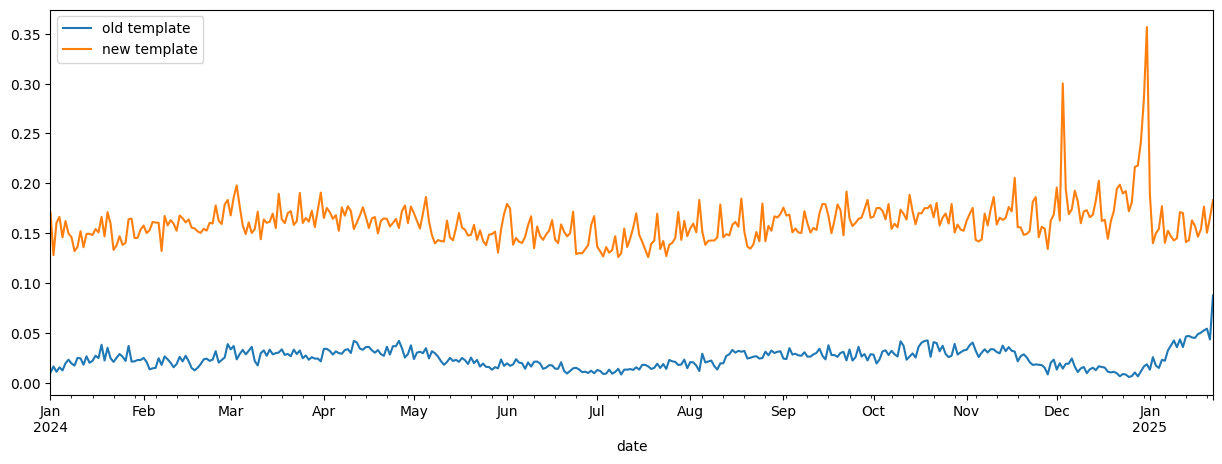

In [48]:
template_date_conv = dailies.groupby(['date', 'is new template'])['conversion'].mean().reset_index()
template_date_conv = template_date_conv.pivot(index='date', columns='is new template', values='conversion').reset_index()
template_date_conv.columns = ['date', 'old template', 'new template']
template_date_conv.plot(x='date', figsize=(15,5))

<AxesSubplot:xlabel='date'>

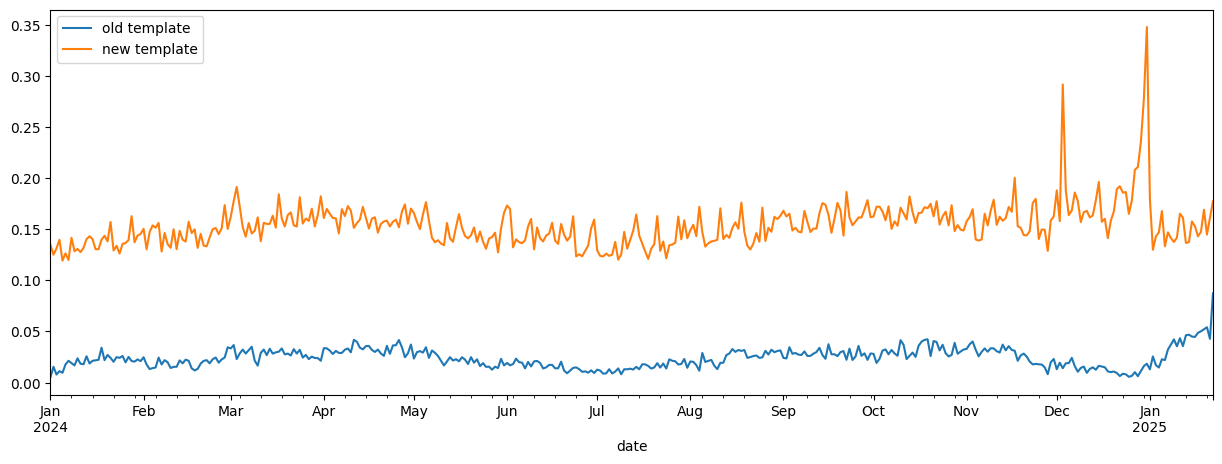

In [49]:
temp_ot_date_conv = dailies.groupby(['date', 'is new template'])['conversion_onetime'].mean().reset_index()
temp_ot_date_conv = temp_ot_date_conv.pivot(index='date', columns='is new template', values='conversion_onetime').reset_index()
temp_ot_date_conv.columns = ['date', 'old template', 'new template']
temp_ot_date_conv.plot(x='date', figsize=(15,5))

<AxesSubplot:xlabel='date'>

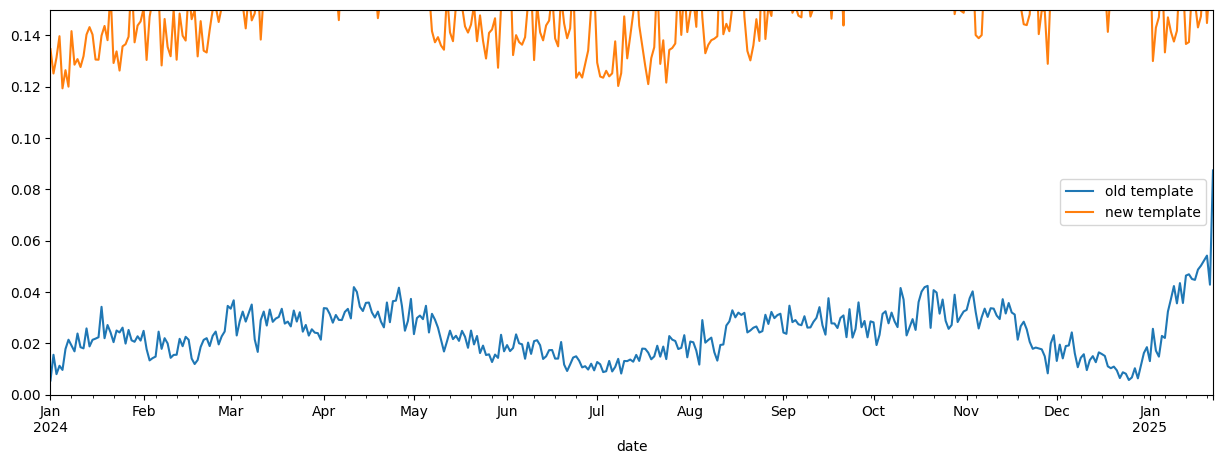

In [50]:
temp_ot_date_conv.plot(x='date', figsize=(15,5), ylim=(0,0.15))

<AxesSubplot:xlabel='date'>

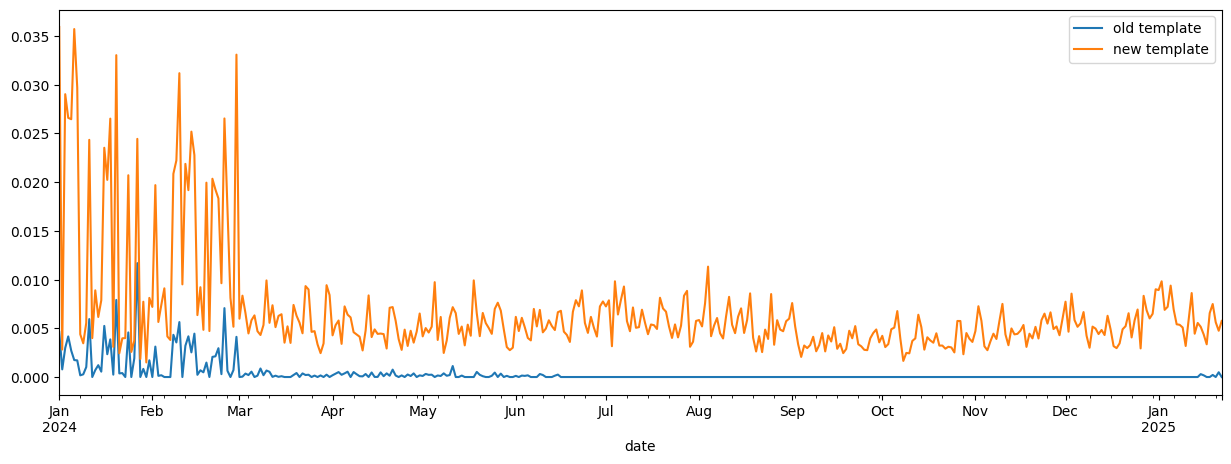

In [51]:
temp_rec_date_conv = dailies.groupby(['date', 'is new template'])['conversion_recurring'].mean().reset_index()
temp_rec_date_conv = temp_rec_date_conv.pivot(index='date', columns='is new template', values='conversion_recurring').reset_index()
temp_rec_date_conv.columns = ['date', 'old template', 'new template']
temp_rec_date_conv.plot(x='date', figsize=(15,5))

In [52]:
dailies[dailies['is new template']].sort_values('conversion_recurring', ascending=False).head()

,date,form,views,bounces,is new template,is embed,trans_count_onetime,trans_count_recurring,trans_vol_onetime,trans_vol_recurring,conversion,conversion_onetime,conversion_recurring
62281,2024-02-27,1015342,11.0,0.0,True,False,0.0,10.0,0.0,730.0,0.909091,0.0,0.909091
252668,2024-07-28,1024309,10.0,0.0,True,True,0.0,9.0,0.0,1008.0,0.900000,0.0,0.900000
125162,2024-04-22,1015342,9.0,0.0,True,False,0.0,8.0,0.0,1180.0,0.888889,0.0,0.888889
56653,2024-02-22,221249,8.0,0.0,True,True,0.0,7.0,0.0,185.0,0.875000,0.0,0.875000
158874,2024-05-21,1015342,8.0,0.0,True,False,0.0,7.0,0.0,165.0,0.875000,0.0,0.875000


In [53]:
len(dailies), len(dailies[dailies['conversion']>1.]), "{:.2f}%".format((len(dailies[dailies['conversion']>1.]) / len(dailies)) * 100.)

(496916, 0, '0.00%')

In [54]:
over_conv_forms = dailies[dailies['conversion']>1.]['form'].unique().tolist()
intersect_over_conv = [f for f in over_conv_forms if f in dailies[dailies['conversion']<1.]['form'].unique()]

print("{:,} forms w/ > 100% conversion".format(len(over_conv_forms)))
print("{:,} forms overlap w/ < 100% conversion".format(len(intersect_over_conv)))

0 forms w/ > 100% conversion
0 forms overlap w/ < 100% conversion


In [55]:
print(len(dailies[dailies['conversion_onetime']>1.]), len(dailies[dailies['conversion_recurring']>1.]))
print("one time: {:.2f}%".format((len(dailies[dailies['conversion_onetime']>1.]) / len(dailies)) * 100.))
print("recurring: {:.2f}%".format((len(dailies[dailies['conversion_recurring']>1.]) / len(dailies)) * 100.))

0 0
one time: 0.00%
recurring: 0.00%


In [56]:
print("total: {:,}".format(len(dailies[dailies['conversion']>1.])))
print("new template: {:,}".format(len(dailies[(dailies['is new template'])&(dailies['conversion']>1.)])))
print("old template: {:,}".format(len(dailies[(dailies['conversion']>1.)&(~dailies['is new template'])])))
print("embed: {:,}".format(len(dailies[(dailies['conversion']>1.)&(dailies['is embed'])])))
print("not embed: {:,}".format(len(dailies[(dailies['conversion']>1.)&(~dailies['is embed'])])))

print()
print("old template & embed: {:,}".format(len(dailies[(~dailies['is new template'])&(dailies['is embed'])&(dailies['conversion']>1.)])))

total: 0
new template: 0
old template: 0
embed: 0
not embed: 0

old template & embed: 0


<AxesSubplot:xlabel='date'>

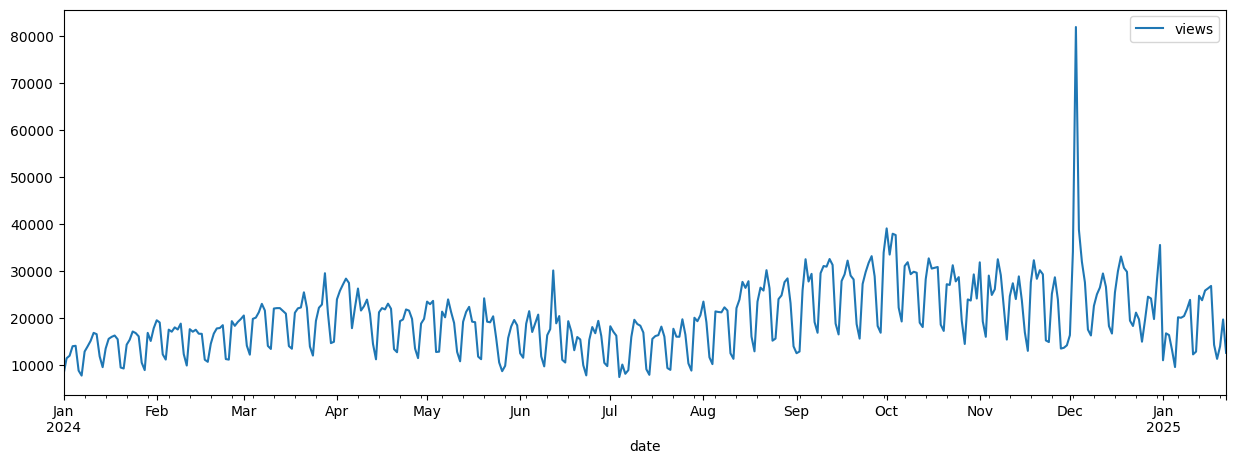

In [57]:
traff_date = traffic.groupby('date')['views'].sum().reset_index()
traff_date.plot(x='date', figsize=(15,5))

<AxesSubplot:xlabel='date'>

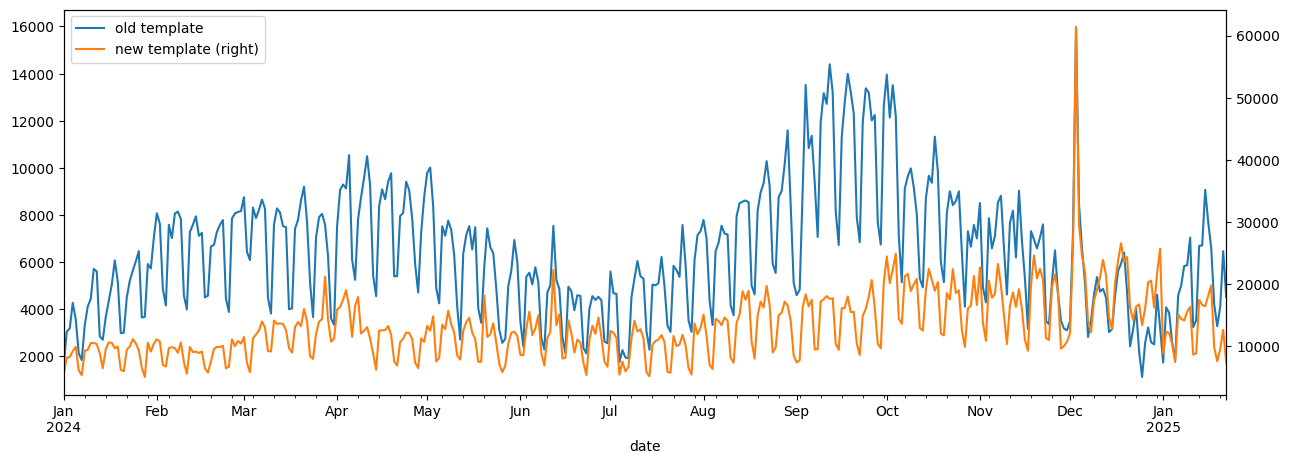

In [58]:
template_date_traf = dailies.groupby(['date', 'is new template'])['views'].sum().reset_index()
template_date_traf = template_date_traf.pivot(index='date', columns='is new template', values='views').reset_index()
template_date_traf.columns = ['date', 'old template', 'new template']
template_date_traf.plot(x='date', secondary_y='new template', figsize=(15,5))

<AxesSubplot:xlabel='date'>

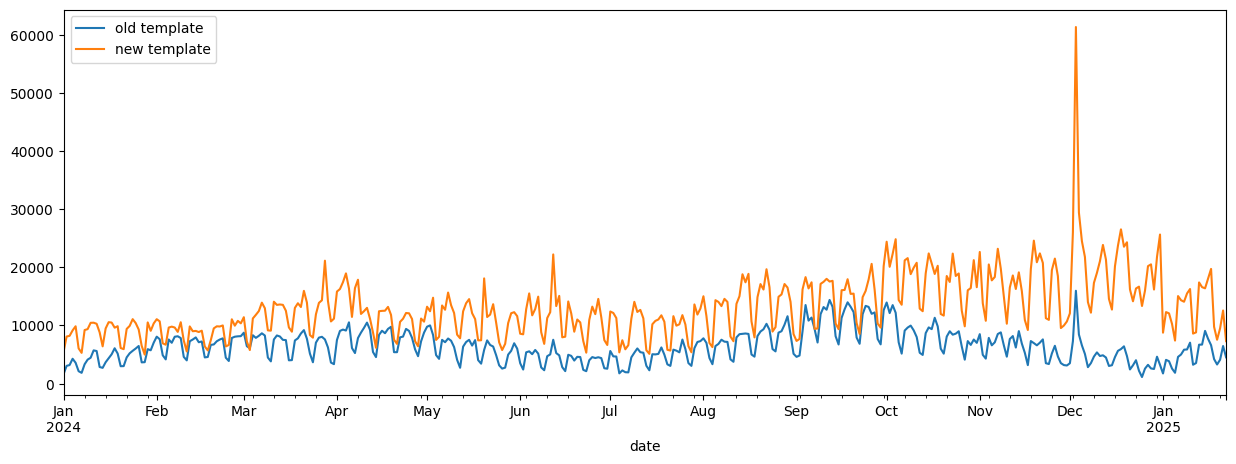

In [59]:
template_date_traf.plot(x='date', figsize=(15,5))

In [60]:
dailies['trans_count'] = dailies['trans_count_onetime'] + dailies['trans_count_recurring']

<AxesSubplot:xlabel='date'>

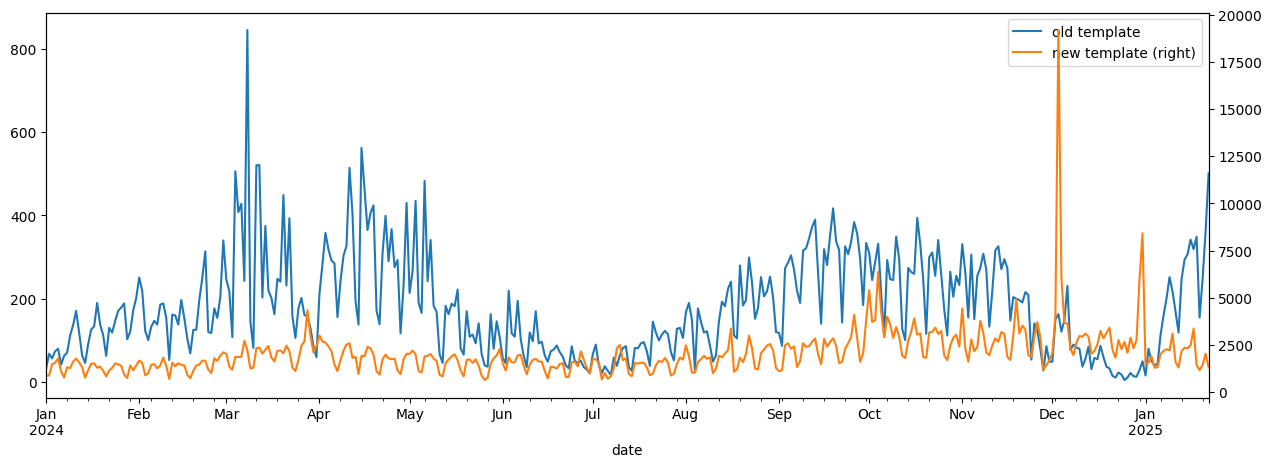

In [61]:
template_date_trans = dailies.groupby(['date', 'is new template'])['trans_count'].sum().reset_index()
template_date_trans = template_date_trans.pivot(index='date', columns='is new template', values='trans_count').reset_index()
template_date_trans.columns = ['date', 'old template', 'new template']
template_date_trans.plot(x='date', secondary_y='new template', figsize=(15,5))

In [62]:
dailies['trans_vol'] = dailies['trans_vol_onetime'] + dailies['trans_vol_recurring']

<AxesSubplot:xlabel='date'>

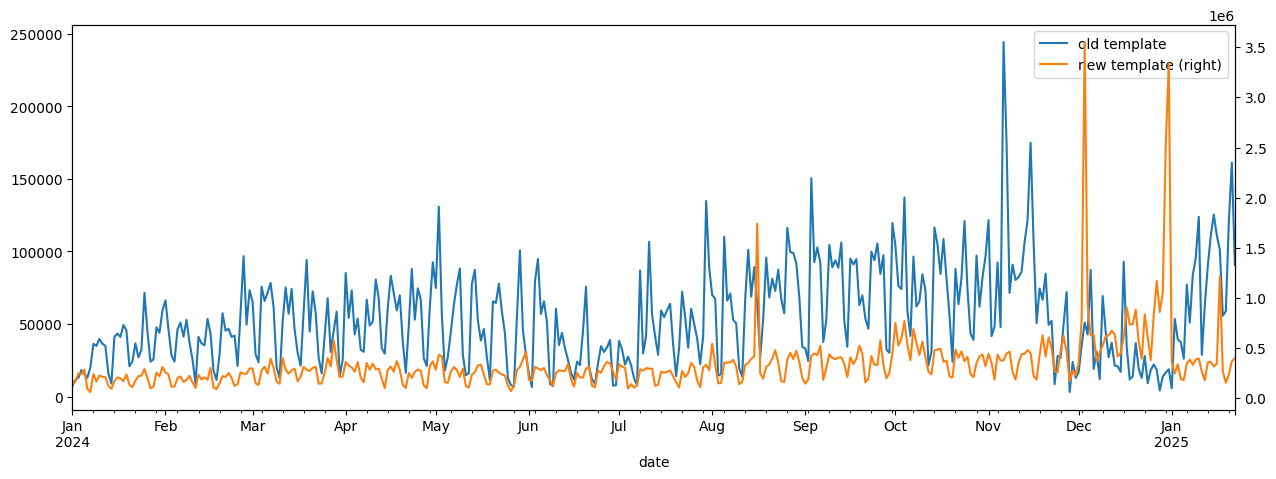

In [63]:
template_date_trans = dailies.groupby(['date', 'is new template'])['trans_vol'].sum().reset_index()
template_date_trans = template_date_trans.pivot(index='date', columns='is new template', values='trans_vol').reset_index()
template_date_trans.columns = ['date', 'old template', 'new template']
template_date_trans.plot(x='date', secondary_y='new template', figsize=(15,5))

In [64]:
template_date_trans.iloc[-28:-23]

,date,old template,new template
360,2024-12-26,22107.62,829736.48
361,2024-12-27,18327.00,1169260.99
362,2024-12-28,4166.48,860432.54
363,2024-12-29,13764.44,1051653.21
364,2024-12-30,16408.63,2527750.87


_Re: new template spike on 10-04, secure reports for donation form processing shows a similar spike so it appears legit_

#### monthly median transactions

In [65]:
trans['month'] = trans['date'].dt.to_period('M')
trans_monthly_median = trans[~trans['is_recurring']].groupby(['month', 'is new template'])['amount'].agg({'median', 'count'}).reset_index()

In [66]:
monthly_medians = trans_monthly_median.pivot(index='month', columns='is new template', values=['count', 'median']).reset_index()
monthly_medians.columns = ['month', 'old template count', 'new template count', 'old template median', 'new template median']

<AxesSubplot:xlabel='month'>

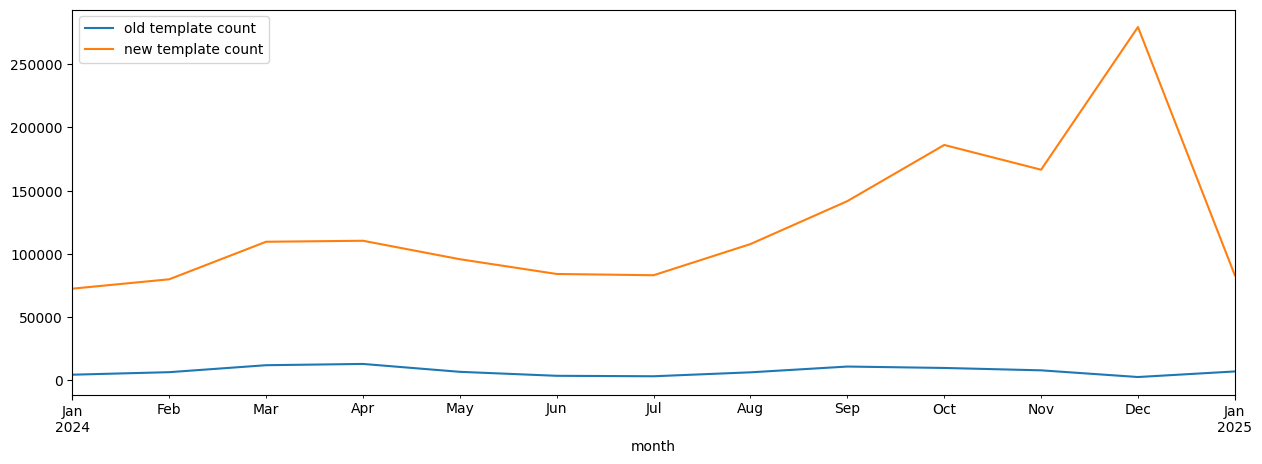

In [67]:
monthly_medians.plot(x='month', y=['old template count', 'new template count'], figsize=(15,5))

<AxesSubplot:xlabel='month'>

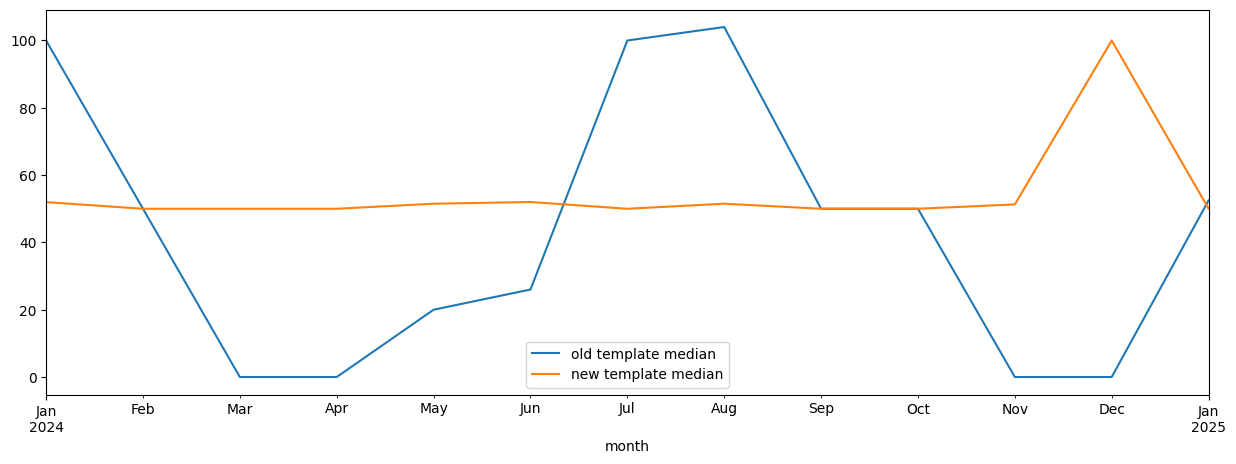

In [68]:
monthly_medians.plot(x='month', y=['old template median', 'new template median'], figsize=(15,5))

In [69]:
trans_monthly_sums = trans[~trans['is_recurring']].groupby(['month', 'is new template'])['amount'].sum().reset_index()

In [70]:
monthly_sums = trans_monthly_sums.pivot(index='month', columns='is new template', values=['amount']).reset_index()
monthly_sums.columns = ['month', 'old template vol', 'new template vol']

<AxesSubplot:xlabel='month'>

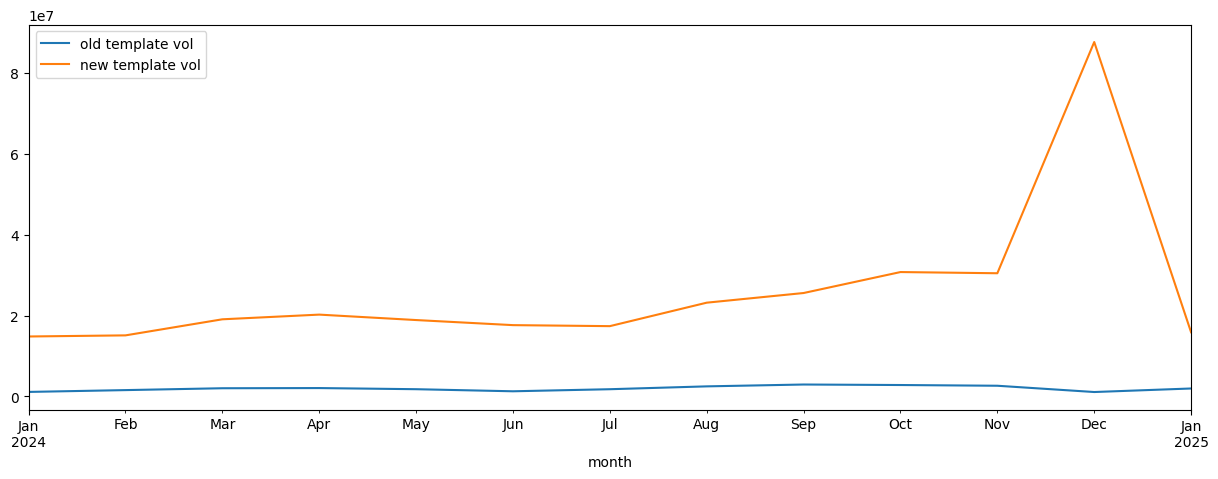

In [71]:
monthly_sums.plot(x='month', figsize=(15,5))

In [72]:
trans_monthly_counts = trans.groupby(['month', 'is new template', 'is_recurring'])['id'].nunique().reset_index()
trans_monthly_counts = trans_monthly_counts.pivot(index='month', columns=['is new template', 'is_recurring'], values='id').reset_index()
trans_monthly_counts.columns = ['month', 'one time old template', 
                                'recurring old template', 'one time new template',
                                'recurring new template']

<AxesSubplot:xlabel='month'>

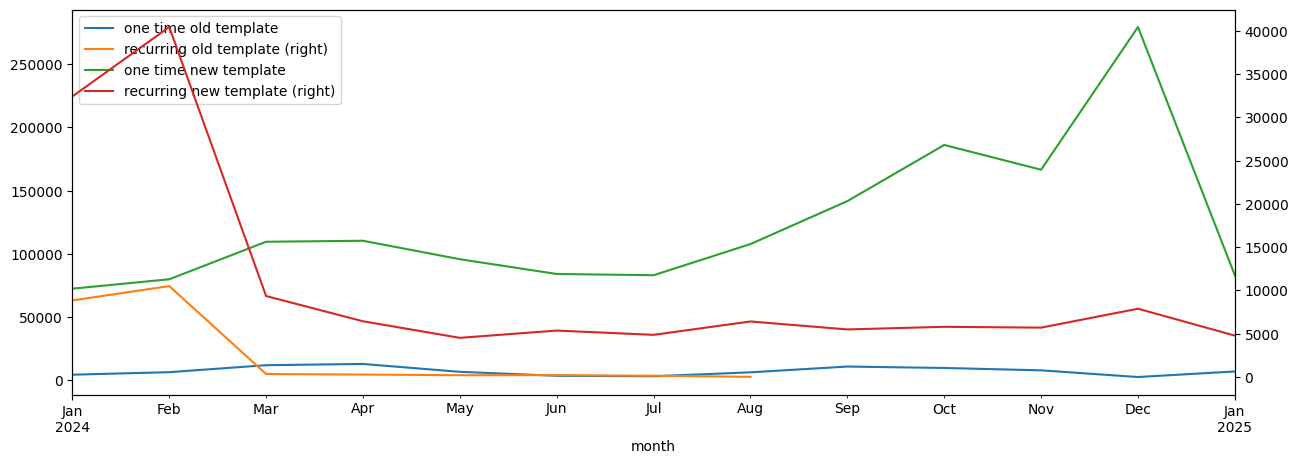

In [73]:
secondary_ys = ['recurring old template', 'recurring new template']
trans_monthly_counts.plot(x='month', secondary_y=secondary_ys, figsize=(15,5))

#### monthly onetime/recurring ratio

In [74]:
trans['month'] = trans['date'].dt.to_period('m')
monthly_ratios = trans.groupby(['month', 'is_recurring', 'is new template'])['id'].nunique().reset_index()

In [75]:
monthly_ratios = monthly_ratios.pivot(index='month', columns=['is_recurring', 'is new template'], values='id').reset_index()
monthly_ratios.columns = ['month', 'onetime old template', 'onetime new template', 'recurring old template', 'recurring new template']
monthly_ratios['new template ratio'] = monthly_ratios['onetime new template'] / monthly_ratios['recurring new template']
monthly_ratios['old template ratio'] = monthly_ratios['onetime old template'] / monthly_ratios['recurring old template']

In [76]:
monthly_ratios.tail(12)

,month,onetime old template,onetime new template,recurring old template,recurring new template,new template ratio,old template ratio
1,2024-02,6355.0,79854.0,10505.0,40418.0,1.975704,0.604950
2,2024-03,11869.0,109537.0,357.0,9359.0,11.703921,33.246499
3,2024-04,12867.0,110338.0,294.0,6446.0,17.117282,43.765306
4,2024-05,6628.0,95724.0,213.0,4532.0,21.121801,31.117371
5,2024-06,3485.0,84048.0,225.0,5372.0,15.645570,15.488889
6,2024-07,3123.0,83056.0,154.0,4879.0,17.023160,20.279221
7,2024-08,6234.0,107716.0,29.0,6422.0,16.772968,214.965517
8,2024-09,10805.0,141692.0,NaN,5503.0,25.748137,NaN
9,2024-10,9693.0,186125.0,NaN,5805.0,32.062877,NaN
10,2024-11,7809.0,166539.0,NaN,5711.0,29.161093,NaN


<AxesSubplot:xlabel='month'>

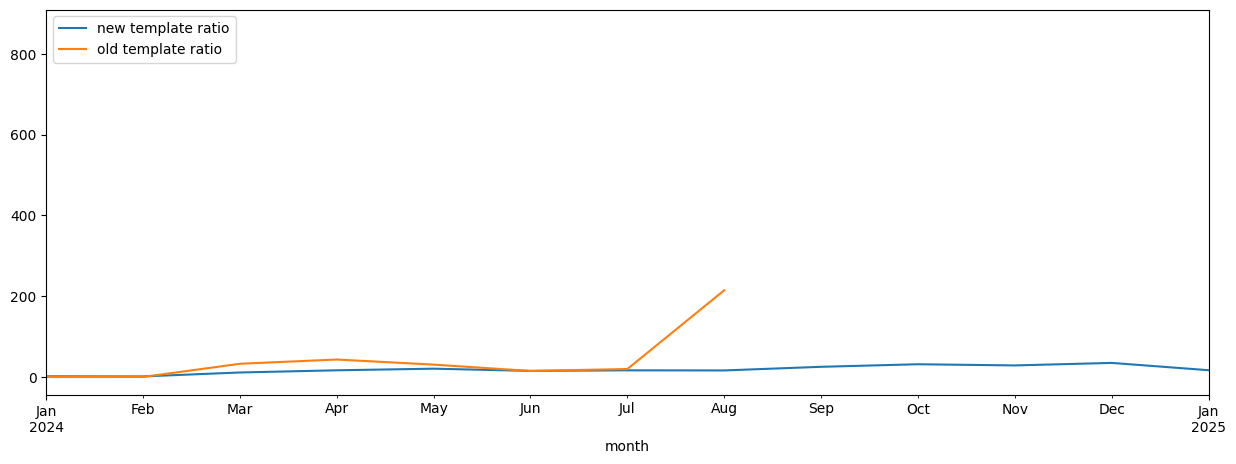

In [77]:
monthly_ratios[['month', 'new template ratio', 'old template ratio']].plot(x='month', figsize=(15,5))

<AxesSubplot:xlabel='month'>

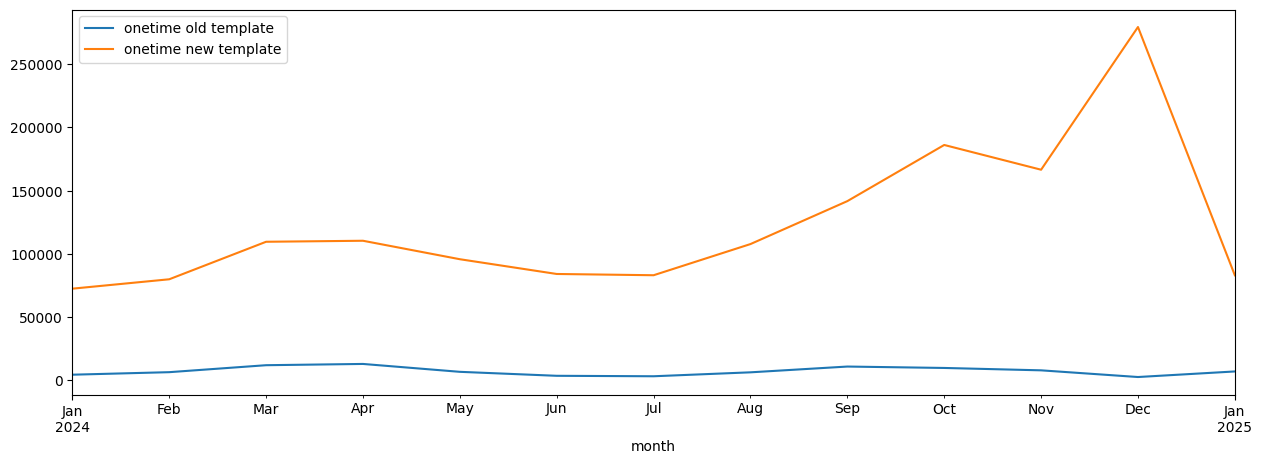

In [78]:
monthly_ratios[['month', 'onetime old template', 'onetime new template']].plot(x='month', figsize=(15,5))

<AxesSubplot:xlabel='month'>

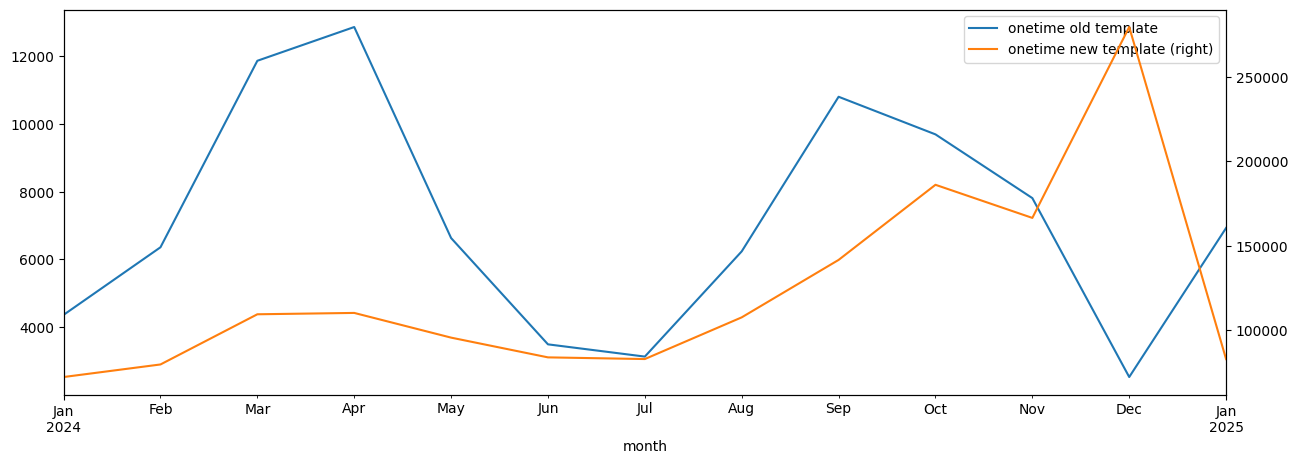

In [79]:
monthly_ratios[['month', 'onetime old template', 'onetime new template']].plot(x='month', secondary_y='onetime new template', figsize=(15,5))

<AxesSubplot:xlabel='month'>

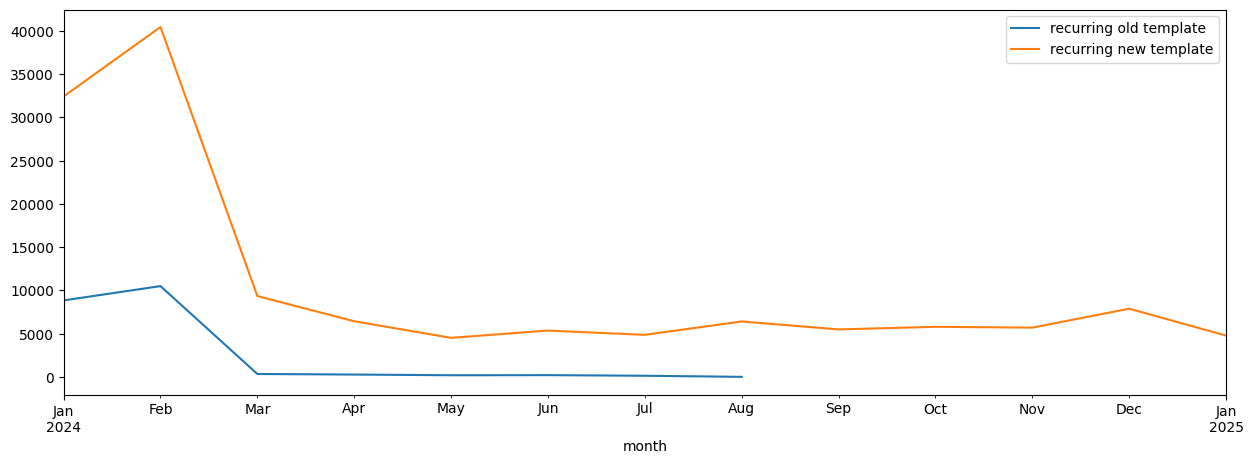

In [80]:
monthly_ratios[['month', 'recurring old template', 'recurring new template']].plot(x='month', figsize=(15,5))

<AxesSubplot:xlabel='month'>

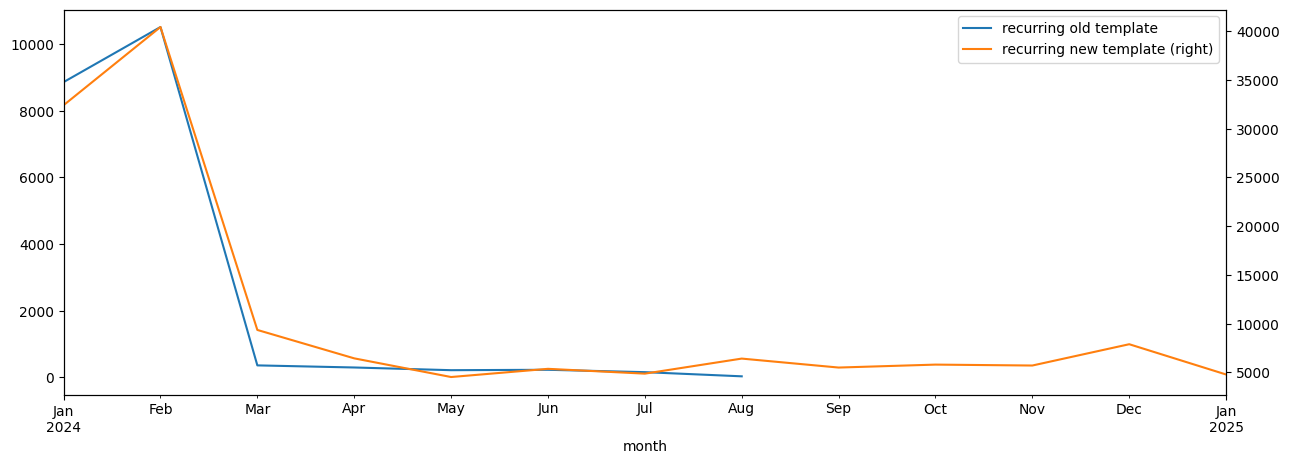

In [81]:
monthly_ratios[['month', 'recurring old template', 'recurring new template']].plot(x='month', secondary_y='recurring new template', figsize=(15,5))

- one time / recurring over time, one time, recurring, recurring all vs originating
- over time, table

In [82]:
daily_onetime = trans[~trans['is_recurring']].groupby(['date', 'is new template'])['id'].nunique().reset_index()
daily_onetime = daily_onetime.pivot(index='date', columns='is new template', values='id').reset_index()
daily_onetime.columns = ['date', 'old template onetime', 'new template onetime']

daily_rec_originating = trans[trans['is_recurring']].groupby(['date', 'is new template'])['id'].nunique().reset_index()
daily_rec_originating = daily_rec_originating.pivot(index='date', columns='is new template', values='id').reset_index()
daily_rec_originating.columns = ['date', 'old template rec origin', 'new template rec origin']

daily_rec_all = trans_all[trans_all['is_recurring']].groupby(['date', 'is new template'])['id'].nunique().reset_index()
daily_rec_all = daily_rec_all.pivot(index='date', columns='is new template', values='id').reset_index()
daily_rec_all.columns = ['date', 'old template rec all', 'new template rec all']

daily_trans = daily_onetime.merge(daily_rec_originating, on='date', how='outer').merge(daily_rec_all, on='date', how='outer')

In [83]:
daily_trans.tail(3)

,date,old template onetime,new template onetime,old template rec origin,new template rec origin,old template rec all,new template rec all
385,2025-01-20,468,2989,NaN,194.0,NaN,3646.0
386,2025-01-21,621,4170,3.0,179.0,6.0,3595.0
387,2025-01-22,930,5031,NaN,249.0,NaN,3581.0


In [84]:
daily_trans['new template onetime / rec origin'] = daily_trans['new template onetime'] / daily_trans['new template rec origin']
daily_trans['new template onetime / rec all'] = daily_trans['new template onetime'] / daily_trans['new template rec all']

daily_trans['old template onetime / rec origin'] = daily_trans['old template onetime'] / daily_trans['old template rec origin']
daily_trans['old template onetime / rec all'] = daily_trans['old template onetime'] / daily_trans['old template rec all']

<AxesSubplot:xlabel='date'>

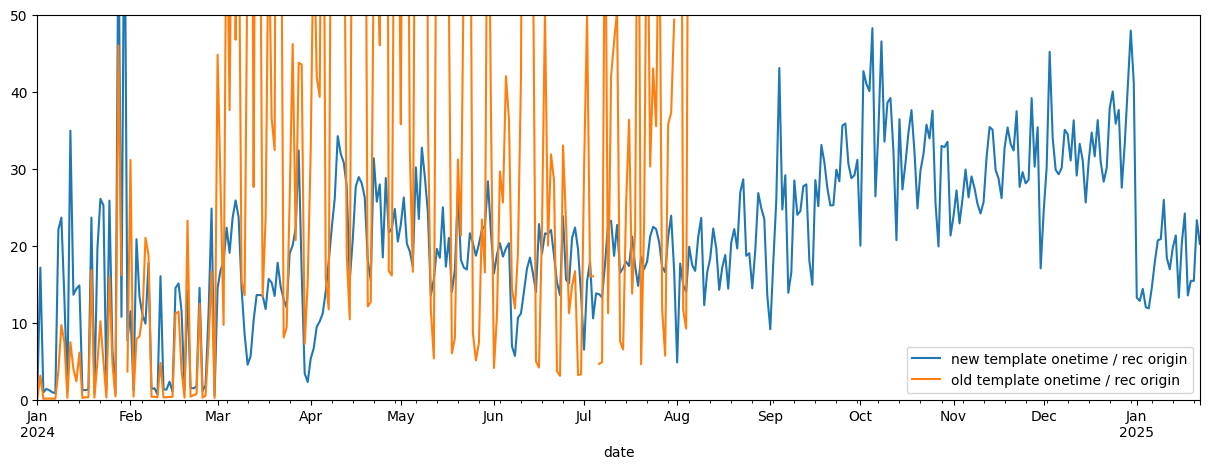

In [85]:
cols = ['date', 'new template onetime / rec origin', 
        'old template onetime / rec origin']
daily_trans[cols].plot(x='date', ylim=(0,50), figsize=(15,5))

In [86]:
cols = ['old template onetime', 'new template onetime',
       'old template rec origin', 'new template rec origin',
       'old template rec all', 'new template rec all']
monthly_trans = daily_trans.groupby(daily_trans['date'].dt.to_period('m'))[cols].sum().reset_index()

In [87]:
monthly_trans['new template onetime / rec origin'] = monthly_trans['new template onetime'] / monthly_trans['new template rec origin']
monthly_trans['new template onetime / rec all'] = monthly_trans['new template onetime'] / monthly_trans['new template rec all']

monthly_trans['old template onetime / rec origin'] = monthly_trans['old template onetime'] / monthly_trans['old template rec origin']
monthly_trans['old template onetime / rec all'] = monthly_trans['old template onetime'] / monthly_trans['old template rec all']

In [88]:
monthly_trans

,date,old template onetime,new template onetime,old template rec origin,new template rec origin,old template rec all,new template rec all,new template onetime / rec origin,new template onetime / rec all,old template onetime / rec origin,old template onetime / rec all
0,2024-01,4357,72424,8853.0,32403.0,19630.0,77048.0,2.235102,0.939985,0.492150,0.221956
1,2024-02,6355,79854,10505.0,40418.0,19100.0,76296.0,1.975704,1.046634,0.604950,0.332723
2,2024-03,11869,109537,357.0,9359.0,18768.0,127005.0,11.703921,0.862462,33.246499,0.632406
3,2024-04,12867,110338,294.0,6446.0,17835.0,137025.0,17.117282,0.805240,43.765306,0.721447
4,2024-05,6628,95724,213.0,4532.0,16613.0,83428.0,21.121801,1.147385,31.117371,0.398965
5,2024-06,3485,84048,225.0,5372.0,11364.0,99565.0,15.645570,0.844152,15.488889,0.306670
6,2024-07,3123,83056,154.0,4879.0,4715.0,97981.0,17.023160,0.847675,20.279221,0.662354
7,2024-08,6234,107716,29.0,6422.0,820.0,104497.0,16.772968,1.030805,214.965517,7.602439
8,2024-09,10805,141692,0.0,5503.0,1.0,106187.0,25.748137,1.334363,inf,10805.000000
9,2024-10,9693,186125,0.0,5805.0,1.0,109513.0,32.062877,1.699570,inf,9693.000000


#### monthly volumes

In [89]:
these_trans = trans[(trans['is new template'])&(trans['month']=='2021-07')]

print("07/2021 new template transactions: {:,}".format(len(these_trans)))
print("\tunique transactions: {:,}".format(these_trans['id'].nunique()))
print()

these_trans.sort_values('amount').tail()

07/2021 new template transactions: 0
	unique transactions: 0



,id,date,form,amount,recurring,source,useragent,is_recurring,is new template,is embed,month


In [90]:
monthly_volume = trans.groupby(['month', 'is new template'])['amount'].sum().reset_index()

In [91]:
monthly_vol = monthly_volume.pivot(index='month', columns='is new template', values='amount').reset_index()
monthly_vol.columns = ['month', 'old template volume', 'new template volume']
monthly_vol.tail()

,month,old template volume,new template volume
8,2024-09,2953705.82,26274715.71
9,2024-10,2829083.34,31607469.02
10,2024-11,2650071.95,31077383.40
11,2024-12,1098640.43,88511226.32
12,2025-01,1972971.48,16402135.40


<AxesSubplot:xlabel='month'>

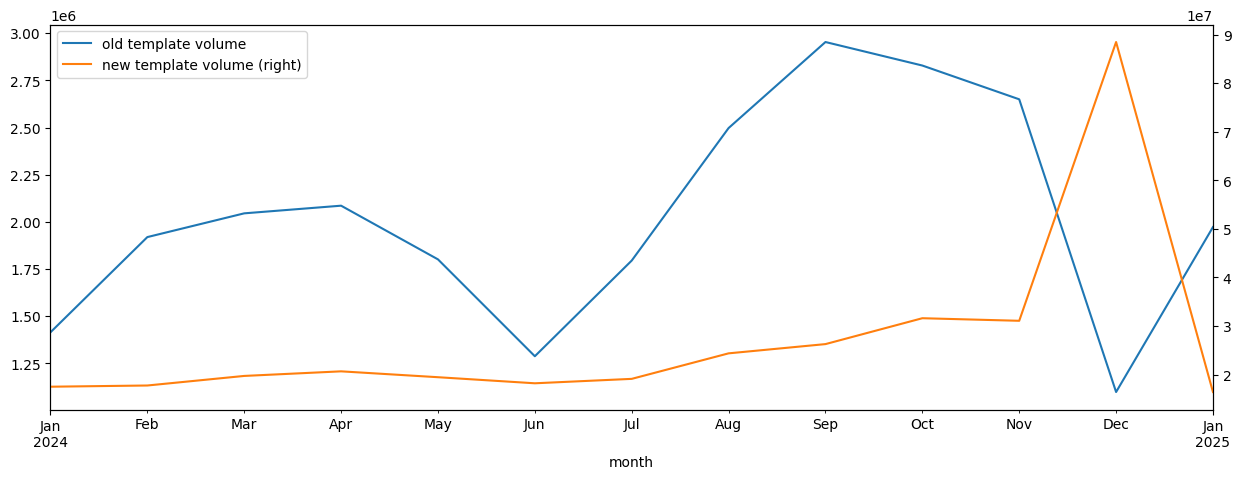

In [92]:
monthly_vol.plot(x='month', secondary_y='new template volume', figsize=(15,5))

#### form sample sizes

In [93]:
print("Dailies:")
print("\tnew template: {:,}".format(len(dailies[dailies['is new template']]['form'].unique())))
print("\told template: {:,}".format(len(dailies[~dailies['is new template']]['form'].unique())))
print()

print("Transactions:")
print("\tnew template: {:,}".format(len(trans[trans['is new template']]['form'].unique())))
print("\told template: {:,}".format(len(trans[~trans['is new template']]['form'].unique())))

Dailies:
	new template: 24,483
	old template: 8,505

Transactions:
	new template: 25,716
	old template: 2,191


In [94]:
daily_forms = dailies.groupby(['date', 'is new template'])['form'].nunique().reset_index()
daily_forms = daily_forms.pivot(index='date', columns='is new template', values='form').reset_index()
daily_forms.columns = ['date', 'old template', 'new template']

<AxesSubplot:xlabel='date'>

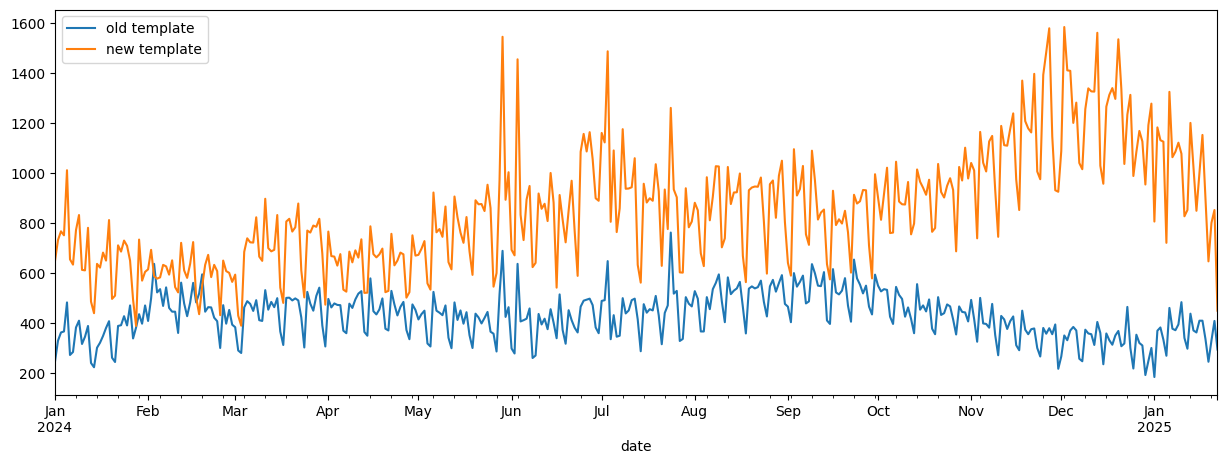

In [95]:
daily_forms.plot(x='date', figsize=(15,5))

In [96]:
daily_trans_forms = trans.groupby(['date', 'is new template'])['form'].nunique().reset_index()
daily_trans_forms = daily_trans_forms.pivot(index='date', columns='is new template', values='form').reset_index()
daily_trans_forms.columns = ['date', 'old template', 'new template']

<AxesSubplot:xlabel='date'>

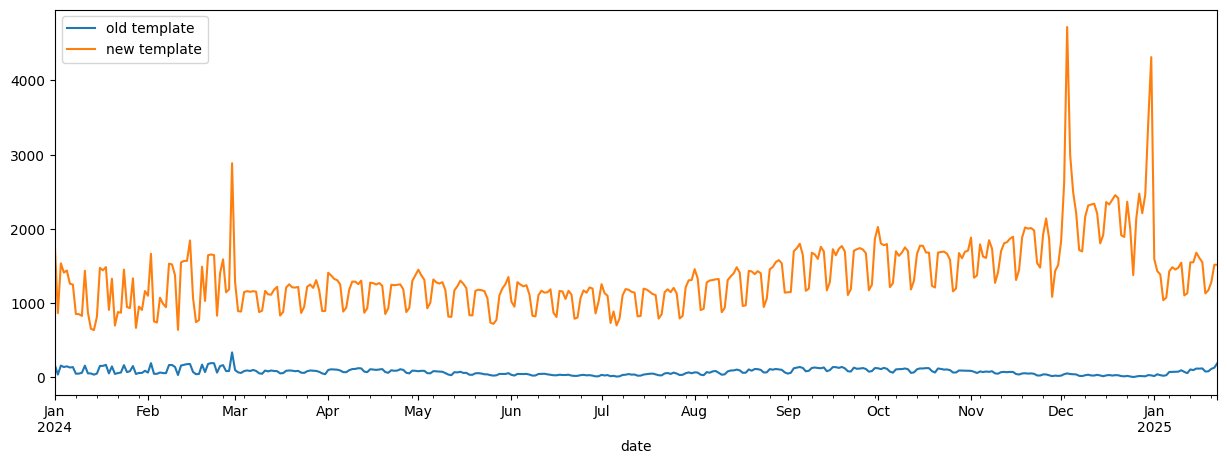

In [97]:
daily_trans_forms.plot(x='date', figsize=(15,5))

#### trans vs dailies one time

In [98]:
daily_onetime = dailies.groupby(['date', 'is new template'])['trans_count_onetime'].sum().reset_index()
daily_onetime = daily_onetime.pivot(index='date', columns='is new template', values='trans_count_onetime').reset_index()
daily_onetime.columns = ['date', 'old template', 'new template']

<AxesSubplot:xlabel='date'>

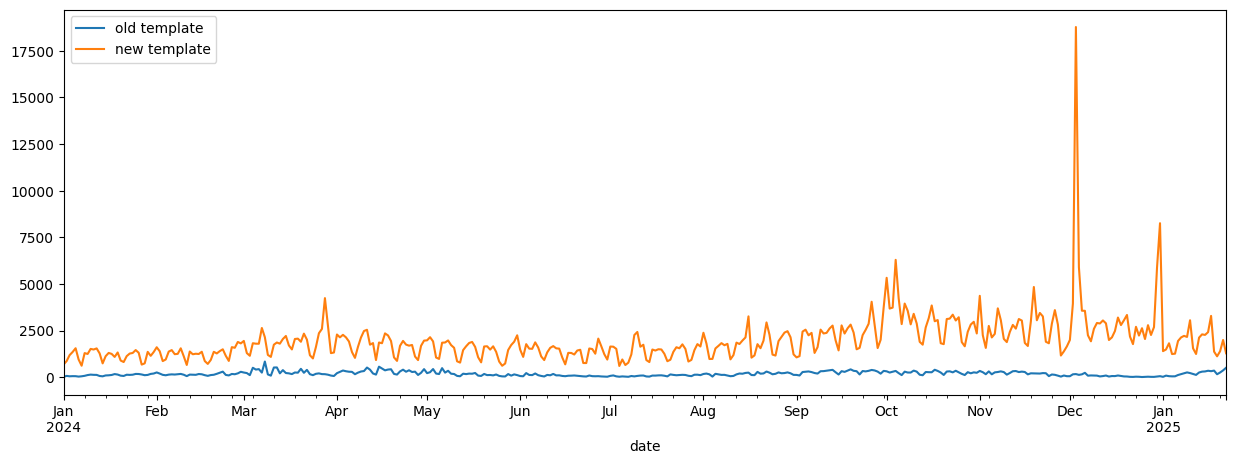

In [99]:
daily_onetime.plot(x='date', figsize=(15,5))

In [100]:
trans_onetime = trans[trans['recurring']==0].groupby(['date', 'is new template'])['id'].nunique().reset_index()
trans_onetime = trans_onetime.pivot(index='date', columns='is new template', values='id').reset_index()
trans_onetime.columns = ['date', 'old template', 'new template']

<AxesSubplot:xlabel='date'>

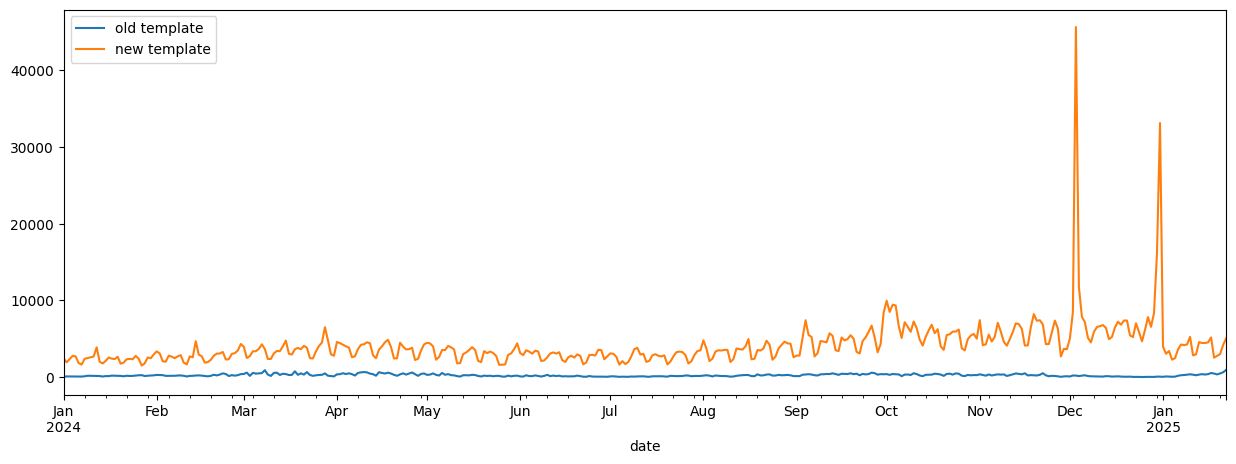

In [101]:
trans_onetime.plot(x='date', figsize=(15,5))

<AxesSubplot:xlabel='date'>

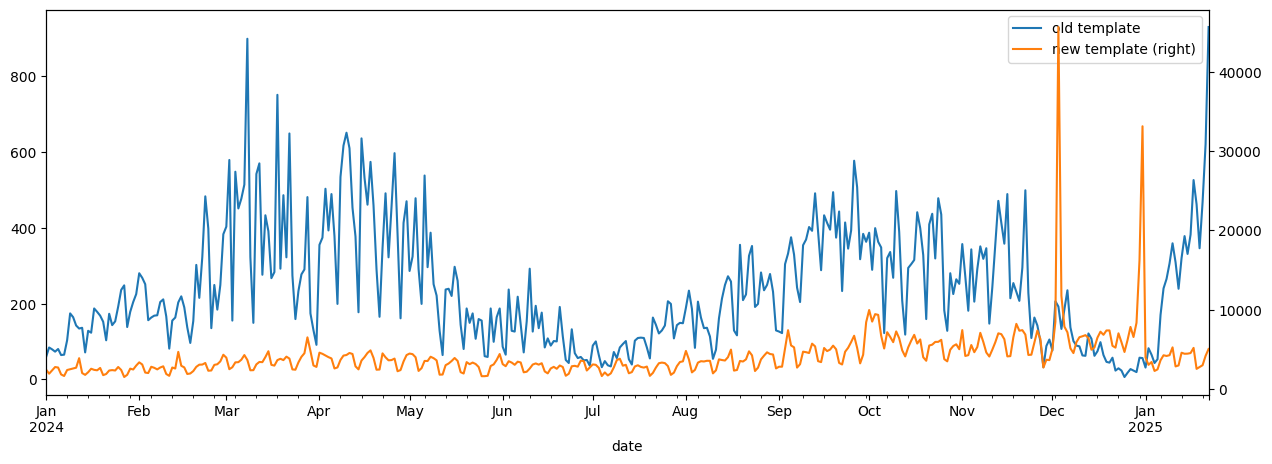

In [102]:
trans_onetime.plot(x='date', secondary_y='new template', figsize=(15,5))

In [103]:
iso_trans = trans[(trans['date']=='2021-02-25')&(trans['is new template'])]
iso_trans.groupby('form')['amount'].sum().reset_index().sort_values('amount').tail()

,form,amount


#### active forms per month

last 90 days, new forms represent 40% by sample size but 6% of the pageviews 

In [104]:
forms_by_month_trans = trans.groupby(['month', 'is new template'])['form'].nunique().reset_index()
forms_by_month_trans = forms_by_month_trans.pivot(index='month', columns='is new template', values='form').reset_index()
forms_by_month_trans.columns = ['month', 'old template forms', 'new template forms']
forms_by_month_trans

,month,old template forms,new template forms
0,2024-01,679,6378
1,2024-02,801,7302
2,2024-03,294,5647
3,2024-04,310,5926
4,2024-05,239,6076
5,2024-06,180,5878
6,2024-07,206,6057
7,2024-08,307,6880
8,2024-09,386,7690
9,2024-10,363,8103


In [105]:
dailies['month'] = dailies['date'].dt.to_period('m')
dailies_traffic_by_month = dailies.groupby(['month', 'is new template'])['views'].sum().reset_index()
dailies_traffic_by_month = dailies_traffic_by_month.pivot(index='month', columns='is new template', values='views').reset_index()
dailies_traffic_by_month.columns = ['month', 'old template', 'new template']

dailies_traffic_by_month['total'] = dailies_traffic_by_month['old template'] + dailies_traffic_by_month['new template']
dailies_traffic_by_month['new template percentage'] = dailies_traffic_by_month['new template'] / dailies_traffic_by_month['total']
dailies_traffic_by_month

,month,old template,new template,total,new template percentage
0,2024-01,132688.0,270841.0,403529.0,0.671181
1,2024-02,194834.0,256733.0,451567.0,0.568538
2,2024-03,211307.0,374646.0,585953.0,0.639379
3,2024-04,238006.0,363894.0,601900.0,0.604576
4,2024-05,185869.0,350283.0,536152.0,0.653328
5,2024-06,124687.0,336397.0,461084.0,0.729579
6,2024-07,145041.0,303410.0,448451.0,0.676573
7,2024-08,228083.0,417842.0,645925.0,0.646889
8,2024-09,319122.0,435555.0,754677.0,0.577141
9,2024-10,262398.0,560810.0,823208.0,0.681249


# store processed data

In [106]:
bucket = 'qgiv-stats-data'

# send dailies to S3
filename = 'new_forms.dailies.csv'
save_dataframe_to_file(bucket, filename, dailies)

# send transactions to S3
filename = 'new_forms.trans.csv'
save_dataframe_to_file(bucket, filename, trans_all)

uploading to S3
Done
uploading to S3
Done


# report

In [107]:
#dailies = pd.read_csv("dailies.csv")

In [108]:
def report(df, df_all_trans):
    df.replace(np.inf, np.nan, inplace=True)
    return {
        'form sample size': len(df_all_trans['form'].unique().tolist()),
        'transactions': df_all_trans[df_all_trans['recurring']==0]['id'].nunique() + df['trans_count_recurring'].sum(),
        'transactions per form': df_all_trans.groupby('form')['id'].count().mean(),
        'conversion': df['conversion'].mean(),
        'conversion onetime': df['conversion_onetime'].mean(),
        'conversion recurring': df['conversion_recurring'].mean(),
        'mean transaction onetime': df['trans_vol_onetime'].sum() / df['trans_count_onetime'].sum(),
        'median transaction onetime': df_all_trans[~df_all_trans['is_recurring']]['amount'].median(),
        'mean transaction recurring': df['trans_vol_recurring'].sum() / df['trans_count_recurring'].sum(),
        'median transaction recurring': df_all_trans[df_all_trans['is_recurring']]['amount'].median(),
        'onetime/recurring': df['trans_count_onetime'].sum() / df['trans_count_recurring'].sum(),
        'pageviews': df['views'].sum(),
        'bounce rate': df['bounces'].sum() / df['views'].sum(),
        'transactions one time': len(df_all_trans[~df_all_trans['is_recurring']]),
        'transactions origin recurring': df['trans_count_recurring'].sum(), 
        'transactions all recurring': len(df_all_trans[df_all_trans['is_recurring']])
    }

### new vs old

In [109]:
data_all = {
    'all': report(dailies, trans_all),
    'new template': report(dailies[dailies['is new template']], trans_all[trans_all['is new template']]),
    'old template': report(dailies[~dailies['is new template']], trans_all[~trans_all['is new template']])
}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [110]:
print("{:%Y-%m-%d} +".format(dailies['date'].min()))
df = pd.DataFrame(data_all)
df = df.transpose()

df['pageviews_perc'] = df['pageviews'] / df['pageviews']['all']
df['pageviews'] = df['pageviews_perc']
df['transactions_perc'] = df['transactions'] / df['transactions']['all']

df.drop(['pageviews_perc', 'transactions_perc'], axis=1, inplace=True)
df.transpose().drop('all', axis=1)

2024-01-01 +


,new template,old template
form sample size,2.639800e+04,2191.000000
transactions,1.633695e+06,93577.000000
transactions per form,1.111532e+02,91.983113
conversion,1.605600e-01,0.024714
conversion onetime,1.543742e-01,0.024374
conversion recurring,6.185773e-03,0.000341
mean transaction onetime,1.711472e+02,304.600987
median transaction onetime,5.195000e+01,35.000000
mean transaction recurring,7.265845e+01,43.369989
median transaction recurring,2.600000e+01,20.800000


In [111]:
trans[['amount', 'is_recurring', 'is new template']].groupby(['is_recurring', 'is new template'])['amount'].median().reset_index()

,is_recurring,is new template,amount
0,False,False,35.00
1,False,True,51.95
2,True,False,20.80
3,True,True,30.90


In [112]:
trans[['amount', 'is_recurring', 'is new template']].groupby(['is_recurring', 'is new template'])['amount'].mean().reset_index()

,is_recurring,is new template,amount
0,False,False,277.057651
1,False,True,210.432534
2,True,False,32.929787
3,True,True,100.657084


### all past 90 days

In [113]:
dailies['date'].max()

Timestamp('2025-01-22 00:00:00')

In [114]:
ninety_days_ago = dailies['date'].max() - datetime.timedelta(90)
last_90 = dailies[dailies['date']>=ninety_days_ago]
last_90_all = trans_all[trans_all['date']>=ninety_days_ago]

In [115]:
last_90['date'].min(), last_90_all['date'].max()

(Timestamp('2024-10-24 00:00:00'), Timestamp('2025-01-22 00:00:00'))

In [116]:
data_last_90 = {
    'all': report(last_90, last_90_all),
    'new template': report(last_90[last_90['is new template']], last_90_all[last_90_all['is new template']]),
    'old template': report(last_90[~last_90['is new template']], last_90_all[~last_90_all['is new template']])
}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [117]:
print("{:%Y-%m-%d} +".format(last_90['date'].min()))
df = pd.DataFrame(data_last_90)
df = df.transpose()

df['pageviews_perc'] = df['pageviews'] / df['pageviews']['all']
df['pageviews'] = df['pageviews_perc']
df['transactions_perc'] = df['transactions'] / df['transactions']['all']

df.drop(['pageviews_perc', 'transactions_perc'], axis=1, inplace=True)
df.transpose().drop('all', axis=1)

2024-10-24 +


,new template,old template
form sample size,18115.000000,615.000000
transactions,575262.000000,19503.000000
transactions per form,50.313663,31.733333
conversion,0.172213,0.026294
conversion onetime,0.166986,0.026281
conversion recurring,0.005228,0.000013
mean transaction onetime,197.160251,382.459191
median transaction onetime,57.200000,50.000000
mean transaction recurring,104.256517,78.530000
median transaction recurring,26.000000,51.325000


In [118]:
trans_last_90 = trans[trans['date']>=ninety_days_ago]
trans_last_90[['is_recurring', 'is new template', 'amount']].groupby(['is_recurring', 'is new template'])['amount'].median().reset_index()

,is_recurring,is new template,amount
0,False,False,50.000
1,False,True,57.200
2,True,False,65.135
3,True,True,36.050


### all past 30 days

In [119]:
thirty_days_ago = dailies['date'].max() - datetime.timedelta(30)
last_30 = dailies[dailies['date']>=thirty_days_ago]
last_30_all = trans_all[trans_all['date']>=thirty_days_ago]

In [120]:
last_30['date'].min(), last_30['date'].max()

(Timestamp('2024-12-23 00:00:00'), Timestamp('2025-01-22 00:00:00'))

In [121]:
last_30['date'].min(), last_30_all['date'].min()

(Timestamp('2024-12-23 00:00:00'), Timestamp('2024-12-23 00:00:00'))

In [122]:
data_last_30 = {
    'all': report(last_30, last_30_all),
    'new template': report(last_30[last_30['is new template']], last_30_all[last_30_all['is new template']]),
    'old template': report(last_30[~last_30['is new template']], last_30_all[~last_30_all['is new template']])
}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [123]:
print("{:%Y-%m-%d} +".format(last_30['date'].min()))
df = pd.DataFrame(data_last_30)
df = df.transpose()

df['pageviews_perc'] = df['pageviews'] / df['pageviews']['all']
df['pageviews'] = df['pageviews_perc']
df['transactions_perc'] = df['transactions'] / df['transactions']['all']

df.drop(['pageviews_perc', 'transactions_perc'], axis=1, inplace=True)
df.transpose().drop('all', axis=1)

2024-12-23 +


,new template,old template
form sample size,13839.000000,372.000000
transactions,180687.000000,7188.000000
transactions per form,21.461160,19.352151
conversion,0.179158,0.031691
conversion onetime,0.173001,0.031650
conversion recurring,0.006158,0.000041
mean transaction onetime,262.574277,390.363094
median transaction onetime,100.000000,53.000000
mean transaction recurring,123.948126,78.530000
median transaction recurring,26.000000,52.650000


In [124]:
trans_last_30 = trans[trans['date']>=thirty_days_ago]
trans_last_30[['is_recurring', 'is new template', 'amount']].groupby(['is_recurring', 'is new template'])['amount'].median().reset_index()

,is_recurring,is new template,amount
0,False,False,53.000
1,False,True,100.000
2,True,False,65.135
3,True,True,36.000


### embeds

##### all embeds

In [125]:
dailies.groupby('is embed')['conversion'].mean()

is embed
False    0.101375
True     0.171625
Name: conversion, dtype: float64

In [126]:
data_all = {
    'all': report(dailies, trans_all),
    'embed': report(dailies[dailies['is embed']], trans_all[trans_all['is embed']]),
    'not embed': report(dailies[~dailies['is embed']], trans_all[~trans_all['is embed']])
}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [127]:
print("Embeds {:%Y-%m-%d} +".format(dailies['date'].min()))
df = pd.DataFrame(data_all)
df = df.transpose()

df['pageviews_perc'] = df['pageviews'] / df['pageviews']['all']
df['pageviews'] = df['pageviews_perc']
df['transactions_perc'] = df['transactions'] / df['transactions']['all']

df.drop(['pageviews_perc', 'transactions_perc'], axis=1, inplace=True)
df.transpose().drop('all', axis=1)

Embeds 2024-01-01 +


,embed,not embed
form sample size,8674.000000,1.916900e+04
transactions,711912.000000,1.015360e+06
transactions per form,160.821997,9.081256e+01
conversion,0.171625,1.013747e-01
conversion onetime,0.162561,9.832007e-02
conversion recurring,0.009064,3.054657e-03
mean transaction onetime,192.089313,1.790938e+02
median transaction onetime,60.000000,5.000000e+01
mean transaction recurring,80.215293,6.859968e+01
median transaction recurring,26.500000,2.500000e+01


##### new template embeds

In [128]:
dailies[dailies['is new template']].groupby('is embed')['conversion'].mean()

is embed
False    0.156135
True     0.171207
Name: conversion, dtype: float64

In [129]:
data_all = {
    'all': report(dailies, trans_all),
    'embed': report(dailies[(dailies['is embed'])&(dailies['is new template'])], trans_all[(trans_all['is embed'])&(trans_all['is new template'])]),
    'not embed': report(dailies[(~dailies['is embed'])&(dailies['is new template'])], trans_all[(~trans_all['is embed'])&(trans_all['is new template'])])
}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [130]:
print("Embeds (new template) {:%Y-%m-%d} +".format(dailies['date'].min()))
df = pd.DataFrame(data_all)
df = df.transpose()

df['pageviews_perc'] = df['pageviews'] / df['pageviews']['all']
df['pageviews'] = df['pageviews_perc']
df['transactions_perc'] = df['transactions'] / df['transactions']['all']

df.drop(['pageviews_perc', 'transactions_perc'], axis=1, inplace=True)
df.transpose().drop('all', axis=1)

Embeds (new template) 2024-01-01 +


,embed,not embed
form sample size,8672.000000,17726.000000
transactions,701421.000000,932274.000000
transactions per form,154.060770,90.161683
conversion,0.171207,0.156135
conversion onetime,0.162227,0.151110
conversion recurring,0.008980,0.005024
mean transaction onetime,196.429061,162.342761
median transaction onetime,62.370000,50.000000
mean transaction recurring,81.368421,69.173033
median transaction recurring,30.000000,25.000000


In [131]:
trans[trans['is new template']][['amount', 'is_recurring', 'is embed']].groupby(['is_recurring', 'is embed'])['amount'].median().reset_index()

,is_recurring,is embed,amount
0,False,False,50.00
1,False,True,62.37
2,True,False,27.00
3,True,True,36.00


### Forms w/ trans new & old

In [132]:
new_template_forms = dailies[dailies['is new template']]['form'].unique().tolist()
old_template_overlap = dailies[(~dailies['is new template'])&(dailies['form'].isin(new_template_forms))]['form'].unique().tolist()

print("all forms: {}".format(len(dailies['form'].unique())))
print("new template forms: {}".format(len(new_template_forms)))
print("old template overlap forms: {}".format(len(old_template_overlap)))

all forms: 32954
new template forms: 24483
old template overlap forms: 34


In [133]:
dailies_overlap = dailies[dailies['form'].isin(old_template_overlap)]
trans_all_overlap = trans_all[trans_all['form'].isin(old_template_overlap)]

In [134]:
data_all = {
    'all': report(dailies_overlap, trans_all_overlap),
    'new template': report(dailies_overlap[dailies_overlap['is new template']], trans_all_overlap[trans_all_overlap['is new template']]),
    'old template': report(dailies_overlap[~dailies_overlap['is new template']], trans_all_overlap[~trans_all_overlap['is new template']])
}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [135]:
print("Forms w/ transaction in new & old {:%Y-%m-%d} +".format(dailies['date'].min()))
df = pd.DataFrame(data_all)
df = df.transpose()

df['pageviews_perc'] = df['pageviews'] / df['pageviews']['all']
df['pageviews'] = df['pageviews_perc']
df['transactions_perc'] = df['transactions'] / df['transactions']['all']

df.drop(['pageviews_perc', 'transactions_perc'], axis=1, inplace=True)
df.transpose().drop('all', axis=1)

Forms w/ transaction in new & old 2024-01-01 +


,new template,old template
form sample size,26.000000,24.000000
transactions,8020.000000,9010.000000
transactions per form,1274.384615,1013.958333
conversion,0.135559,0.211463
conversion onetime,0.131685,0.169666
conversion recurring,0.003873,0.041797
mean transaction onetime,12.421602,38.068804
median transaction onetime,0.000000,0.000000
mean transaction recurring,30.481000,44.740699
median transaction recurring,25.000000,25.000000


In [136]:
trans[trans['form'].isin(old_template_overlap)][['amount', 'is_recurring', 'is new template']].groupby(['is_recurring', 'is new template'])['amount'].median().reset_index()

,is_recurring,is new template,amount
0,False,False,0.0
1,False,True,0.0
2,True,False,25.0
3,True,True,25.0
